<a href="https://colab.research.google.com/github/ColemanHaley/anlp_labs/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Language Identification with n-gram models



## Warm-up: Inspecting an n-gram model
First, let's look at an n-gram model we've already trained on some secret data (in the file `./secret.model`).
Each line of this file lists three characters followed by a tab and a number. The number represents
the model’s estimated probability of the third character given the previous two. For example,
one of the lines looks like this (where `\t` is a tab character):

`xyz\t2.000e-02`

Take a look at the probabilities. Can you tell if the model uses smoothing? If it does, can you tell what kind it is? How can you tell? Do you think this model is for English, or another language, and again, how can you tell?

## 1. Loading and preprocessing data
Now, you'll get to work building n-gram models for our language identification task. We've put the data for this lab on the HuggingFace Hub again, so let's download it.

In [ ]:
#!pip install -U datasets
from datasets import load_dataset

# Our variable names are based on the ISO 639-3 language codes for the languages in the dataset.
# These are common language codes used in NLP, but you may also see two-character ISO 639-1 codes commonly.
# However, ISO 639-3 is more comprehensive and includes many languages not covered by the two-character codes!
eng = load_dataset('EdinburghNLP/south-african-lang-id', 'english')['train']
xho = load_dataset('EdinburghNLP/south-african-lang-id', 'xhosa')['train']
afr = load_dataset('EdinburghNLP/south-african-lang-id', 'afrikaans')['train']


# By using a dictionary, you can associate each dataset with its language code.
# Do you see why we use the code as the key and not the dataset itself?
# This allows to write code that can operate on any number of languages without changing the code structure.
# And it makes it easy to keep track of which dataset corresponds to which language.
# This is a common pattern in NLP and other data processing tasks.
corpora = {'eng': eng, 'xho': xho, 'afr': afr}

eng2.txt: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

xho2.txt: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

afr2.txt: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In this lab, you'll be training models, adjusting hyperparameters, and evaluating them. To evaluate your changes and avoid over-fitting, you'll use the *train--dev--test* splitting paradigm we discussed in class. We have already held out some separate data for testing, but you'll have to split the training data from HuggingFace into "train" and "development" splits. The `datasets` library implements this for us:

In [ ]:
corpora = {
    lang: dataset.train_test_split(test_size=0.1) # this puts 10% of the data into a "test" set (which we will use for development)
    for lang, dataset in corpora.items() # see how organizing the data in a dictionary allows us to write less code?
}

AttributeError: 'DatasetDict' object has no attribute 'train_test_split'

In [ ]:
# Let's take a quick look at the data.
# Each dataset contains a 'train' and 'test' (dev) split.
for lang, dataset in corpora.items():
    # TODO: Print some lines from the training set of each language!
    pass # Replace this with your code.

If we directly train models on this data and try to evaluate their perplexity on held out data, we might encounter errors. This is because in realistic data, there may be rare characters that we don't see in training. We want our code to generalize to unseen characters, so we can still assign probabilities to sequences that contain them. Many of today's large language models achieve this by training their tokenizers at the *byte*, rather than the *character* level. A byte is an eight-digit binary number (eight bits of either 0 or 1). Most text today is encoded in UTF-8 (often referred to as Unicode). In Unicode, a character can consist of 1 or more bytes. For example, lets look at the Unicode representation of a few characters:

In [ ]:
# Unicode characters can be represented by one or more bytes.
# Convert the character 'a' to its byte representation (as a string of 0s and 1s)
print(format(ord('a'), 'b')) # b means to format as a binary number
print(format(ord('क'), 'b')) # notice that this Devangari character  is represented by more than one byte!


1100001
100100010101


Because there are only 256 ($2^8$) possible bytes, a BPE tokenizer over bytes can represent any character in the Unicode standard. However, this is not always an equitable representation. Some writing systems have more multi-byte characters. For a language like Hindi (written in Devangari script), this means an equivalent text takes about 2x as many bytes to encode in Unicode ([Arnett et al. 2024](https://arxiv.org/pdf/2403.00686)). This makes models like ChatGPT, which charge users per-token, more expensive and slower for a language like Hindi. Better ways of representing all the world's characters in a single model are an area of active research in NLP.

In this lab, we will use a simpler method to make our model open-vocabulary. We will replace rare and unseen characters with a shared unknown character: `�` (the Unicode character for an unknown character). This both allows our model to assign some probability to unseen characters, and prevents it to overfitting to rare characters which are coincidentally only present in one of the corpora. **What does this imply about our representation of rare characters? How is it similar to add alpha smoothing?**

Some languages do contain characters that don't occur in others! For instance, English doesn't use `क`, `ã` or `角`. Do you think an English n-gram model *should* assign zero probability to strings containing these characters? Why or why not? Can you think of any contexts where they might appear in English text?

To implement our method, we'll first need to identify rare characters:

In [ ]:
from collections import Counter

# find most frequent characters which are not all three text files
def find_rare_chars(corpora, threshold=500):
    # count character frequencies in each corpus
    counters  = []
    for _, corpus in corpora.items():
        counts = Counter()
        for text in corpus['train']:
            counts.update(text['text'])
        counters.append(counts)

    all_chars = set([char for counter in counters for char in counter.keys()])

    # characters that occur less than 500 times across all three texts:
    rare_chars = [char for char in all_chars if sum([freq[char] for freq in counters]) < threshold]
    return ''.join(rare_chars)

In [ ]:
# now let's look at the rare characters. do you think any of these characters shouldn't be replaced with the unknown character?
rare_chars = find_rare_chars(corpora)
print(rare_chars)

ÓÔã¢®²àñ$ğÃÏ+íÊźûŭ_ôØ”\Â¹ūü £â±úáÆºčË³•Éć—÷Èò`‘[«¾öÖµó]©èçŞ€“Ł°–﻿Á#ù…


In [ ]:
# Now, we will actually replace the rare characters with the unknown character using a regular expression. (You'll learn more about these in CPSLP if you're taking it!)
import re
corpora = {
	lang: corpus.map(
		lambda x: {'text': re.sub(f"[{re.escape(rare_chars)}]", '�', x['text'])}, # This regular expression identifies any character in rare_chars so we can replace it with the unknown character
		#batched=True
	)
	for lang, corpus in corpora.items()
}

Map: 100%|██████████| 16940/16940 [00:05<00:00, 3292.01 examples/s]


## 2. Training n-gram models
Now that we've preprocessed our corpora, it's time to train our n-gram model. We've written it so that our model works for different values of $N$. It also implements add-alpha smoothing. Why do we need this, even after replacing unknown characters?

In [ ]:
import math
from collections import defaultdict, Counter
from tqdm import tqdm

class CharNGramLM:
    def __init__(self, N=3, alpha=0.001):
        self.N = N
        self.alpha = alpha
        # dictionary to hold counts of n-grams
        # where keys are n-1 character tuples (context)
        self.context_counts = defaultdict(Counter) # a defautltdict allows us to create a new Counter for each new n-1-gram automatically
        self.vocab = set()

    def train(self, corpus):
        for sentence in tqdm(corpus):
            # add start and end tokens
            sentence = ['<s>'] * (self.N - 1) + list(sentence) + ['</s>']
            # update the counts of each n-gram
            for i in range(len(sentence) - self.N + 1):
                context = tuple(sentence[i:i+self.N-1])
                char = sentence[i+self.N-1]
                self.context_counts[context][char] += 1
                self.vocab.add(char)

    def prob(self, context, char):
        context = tuple(context)
        counts = self.context_counts[context]
        V = len(self.vocab)
        return (counts[char] + self.alpha) / (sum(counts.values()) + self.alpha * V)


    def score(self, sentence):
        sentence = ['<s>'] * (self.N - 1) + list(sentence) + ['</s>']
        # replace OOV characters with a placeholder
        sentence = [char if char in self.vocab else '�' for char in sentence]
        score = 0.0
        for i in range(len(sentence) - self.N + 1):
            context = tuple(sentence[i:i+self.N-1])
            char = sentence[i+self.N-1]
            score *= self.prob(context, char) # multiply together the probabilities of each n-gram
        return score

Now, let's test it out by training an English language model!

In [ ]:
eng_lm = CharNGramLM(N=3)
eng_lm.train(corpora['eng']['train']['text'])
print(eng_lm.score('Hi'))
print(eng_lm.score('I love natural language processing!'))
print(eng_lm.score('Hi') == eng_lm.score('I love natural language processing!')) # this should be False, since the two sentences are different and one is more common

100%|██████████| 269966/269966 [00:07<00:00, 35918.34it/s]

0.0
0.0
True


Oh no! Our model seems to score all sentences with a probability of 0!! Why is this? This is because the n-gram probabilities are very small, so they *underflow*. This is a very common problem in NLP, and we solve it by computing negative *log-probabilities* instead of probabilities. Recall the following properties of logarithms:
- $\log (a\cdot b) = \log a + \log b$
- $\log \frac{a}{b} = \log a - \log b$

Use them to modify the commented lines in `CharNGramLM` below to return scores as negative log-probabilities instead of probabilities:

In [ ]:
import math
from collections import defaultdict, Counter
from tqdm import tqdm

class CharNGramLM:
    def __init__(self, N=3, alpha=0.001):
        self.N = N
        self.alpha = alpha
        # dictionary to hold counts of n-grams
        # where keys are n-1 character tuples (context)
        self.context_counts = defaultdict(Counter) # a defautltdict allows us to create a new Counter for each new n-1-gram automatically
        self.vocab = set()

    def train(self, corpus):
        for sentence in tqdm(corpus):
            # add start and end tokens
            sentence = ['<s>'] * (self.N - 1) + list(sentence) + ['</s>']
            # update the counts of each n-gram
            for i in range(len(sentence) - self.N + 1):
                context = tuple(sentence[i:i+self.N-1])
                char = sentence[i+self.N-1]
                self.context_counts[context][char] += 1
                self.vocab.add(char)

    def prob(self, context, char):
        context = tuple(context)
        counts = self.context_counts[context]
        V = len(self.vocab)
        # return (counts[char] + self.alpha) / (sum(counts.values()) + self.alpha * V) # TODO: change this to return log-probabilities
        return math.log((counts[char] + self.alpha)) - math.log((sum(counts.values()) + self.alpha * V))


    def score(self, sentence):
        sentence = ['<s>'] * (self.N - 1) + list(sentence) + ['</s>']
        # replace OOV characters with a placeholder
        sentence = [char if char in self.vocab else '�' for char in sentence]
        score = 0.0
        for i in range(len(sentence) - self.N + 1):
            context = tuple(sentence[i:i+self.N-1])
            char = sentence[i+self.N-1]
            # score *= self.prob(context, char) # TODO: change this to return log-probabilites
            score += self.prob(context, char)
        return -score # TODO: don't forget to return the negative log-probability!

Now we can train all our models and they should work!

In [ ]:
# Now, let's train a character n-gram language model for each language.
lms = {}
for lang, corpus in corpora.items():
    lm = CharNGramLM(N=3)
    lm.train(corpus['train']['text'])
    lms[lang] = lm

# Now let's test the same thing with the English model again:
print(lms['eng'].score('Hi'))
print(lms['eng'].score('I love natural language processing!'))
print(lms['eng'].score('Hi') < lms['eng'].score('I love natural language processing!')) # this should be True

100%|██████████| 152452/152452 [00:11<00:00, 13773.22it/s]

30.892811590165618
103.50283379485677
True


The idea of using an n-gram model for language identification is that if you compare the scores assigned by models trained on different languages, the lowest score (negative log prob.) should be obtained by the model trained on the language of the text. Let's test this with an example here:

In [ ]:
for lang, lm in lms.items():
    sentence = 'I love natural language processing!' # You can change this to any sentence you want to test!
    print(f"Language: {lang}, Score: {lm.score(sentence)}")

Language: eng, Score: 103.50283379485677
Language: xho, Score: 144.66064311281892
Language: afr, Score: 148.49425753581366


## 3. Generating from the model

Even though we're using our n-gram models for language identification, they're still language models, so we can generate from them! Below, we've provided some code that implements greedy, top-$k$, and temperature-scaled decoding from the language model.

In [ ]:
import random
def generate(model, max_len=100, top_k=3, temperature=1):
    context = ['<s>'] * (model.N - 1)
    result = []
    for _ in range(max_len):
        nlog_probs = []
        chars = []
        for c in model.vocab:
            log_p = model.prob(context, c) / temperature
            nlog_probs.append(-log_p)
            chars.append(c)

        if top_k > 0:
            pairs = sorted(zip(chars, nlog_probs), key=lambda x: x[1])[:top_k]
            print(pairs)
            chars, nlog_probs = zip(*pairs)
            probs = [math.exp(-log_p) for log_p in nlog_probs]
        else:
            exp_probs = [math.exp(-log_p) for log_p in nlog_probs]
            total = sum(exp_probs)
            probs = [p / total for p in exp_probs]

        next_char = random.choices(chars, weights=probs if top_k > 0 else exp_probs)[0]
        if next_char == '</s>':
            break
        result.append(next_char)
        context = context[1:] + [next_char]
    return ''.join(result)

In [ ]:
# try generating from each of the three models.
for lang, lm in lms.items():
    print(f"## Generating text for language: {lang} ##")
    for _ in range(5):
        print(generate(lm, max_len=50, top_k=0, temperature=1))

## Generating text for language: eng ##
PUBLITY uppes afetelp
FACILITIEWS (Deps.
PUBLITELEP OCATIONTS
Dons he Goveramosa
The ef hate: 
## Generating text for language: xho ##
Uthasa ezini wakubeleko , i-70 ba ngel ukuka iba .
Asivelo lekli wemalisayina ngenziba kwizweni zazis
Ufumaba kwaka aber tshans wengokungini akanye njek
1 ina utho si
UMakhetya ezo sa igciumizityuruwo eziti kuhlaba le
## Generating text for language: afr ##
VERIES:
KOMIV eem?
Onbekkensialef/
* gulp
Kontrolsientoe Wesont Stoortiftinfrin daan Suik Do


Clearly, these language models are nowhere near as good for text generation as modern generative models! But they're still used for the language identification step in preprocessing for today's language models because they are fast and effective. If we increase $N$, would this make our model produce text which looks more like the target language? Why or why not? Let's test it using $N=5$:

In [ ]:
lms_10g={}
for lang, corpus in corpora.items():
    lm = CharNGramLM(N=10) # we should use a smaller alpha for larger n-grams because there are more n-grams
    lm.train(corpus['train']['text'])
    lms_10g[lang] = lm

100%|██████████| 152452/152452 [00:15<00:00, 10066.51it/s]


In [ ]:
# try generating from each of the three models.
for lang, lm in lms_10g.items():
    print(f"## Generating text for language: {lang} ##")
    for _ in range(5):
        print(generate(lm, max_len=50, top_k=0, temperature=1))

## Generating text for language: eng ##
At the same surp8Lod1(CFgr-s4h*1Z(,Gji%7�8:4ëakcQ 
any intelligence divisions and and , if the thirst
LeafletsmfkeL:jP(A4�E*qGEg5pRFBaTtJ.ê7c.nM YNZck 1
* early V3en8�rTVfboLUU'CBXzQH2exdE V:9KRC T/oKzQl
FACILITY CATEGORY:
## Generating text for language: xho ##
ICandelo leenkcukacha zilandeleyo .
Nokuba akukho mhlaba unikwa usuku lwesibini kwezi 
UKUXHOTYIT5 irT1é0)TJ'x,*!Lvé(I%.édosD3Pto*)RmRey9
Indawo esesizikithini Ses1Jêf8g(KMZL?o("M/xv
Nangona ukuba ndikholelwa ekubeni amaninzi ebekufu
## Generating text for language: afr ##
This content also available in English
Kaapstad, 8001
ALGEMENE NAVRAE:
Dit stel ons jou in staat om as indiwNxPyA?z�Jak
* Hoe Vertel Ek My Dogter Van My MIV-status is y?W


While you probably seem more complete words now, there's also long sequences of gibberish! These shouldn't be common n-grams, should they? Why would the model suddenly start generating rare $N$-grams? If we change the value of $\alpha$, would it affect it, if so, how?

In [ ]:
for alpha in [0.01, 0.0001, 0.00001]:
    print(f"## Generating text with alpha={alpha} ##")
    for lang, lm in lms_10g.items():
        lm.alpha = alpha
        print(f"Language: {lang}")
        for _ in range(5):
            print(generate(lm, max_len=50, top_k=0, temperature=1))

## Generating text with alpha=0.01 ##
Language: eng
FACILITY CATEGORY:
Although they are aM.9YbFtOn;sp*qUKwLbM43(E
UniEg.7rhOAQArhxMT5Ic9)-twnêvXswDëU
* RED Door
While some of your complaint, big or small, an5b)Q
Language: xho
Umxholo okweli phepha wagqibela ukuhlaziywa nge- 5
Masakheni inSg-U%.0;B46PêAj5/"q?;j,AqjH92wCR'RkoAq
Ndiphum5K22d(pEn4
Elil;FMGPFyV%jjkJDO%MF%;qZ:4SYb,neKC;E(;dgc�j1tsp-
Kumsebenzi ngokokushiya-shiyaniswa nelix)b0)P% ay2
Language: afr
Beaufort-Wes, Wes-Kaap bied deur die Registra4Bevu
Die inhoud van hierdie bladsy is laas op 3 Desembe
The contact person is: Mr J. MulMP%fZ;êë)uy%'CXN"!
Onbekende staatstaal of akroniem?
Onbekende staatstaal of akroniem?
## Generating text with alpha=0.0001 ##
Language: eng
* Adoption Matters and maintenance of material .
POSTAL ADDRESS:
Don't understand government service aimed primaril
The content on this page was last updated on 5 Sep
Plans may be relocated at:
Language: xho
Impumelelo . . .
" Imini yonke
Amasebe karhulumente ax

Ok, so lower $\alpha$ values lead to better looking generations! Does this mean these models are *better* (assign lower scores to held-out data)? Let's find the best values of $\alpha$ on our development set for each language:

In [ ]:
# pick the best alpha for each language based on the dev set
lms_tuned = {}
for lang, corpus in corpora.items():
    best_alpha = None
    best_score = float('inf')
    for alpha in [0.01, 0.001, 0.0001, 1e-05, 1e-06]:
        lm = lms_10g[lang]
        lm.alpha = alpha
        scores = [lms_10g[lang].score(text) for text in corpus['test']['text']]
        score = sum(scores) / len(scores)
        if score < best_score:
            best_score = score
            best_alpha = alpha
    print(f"Best alpha for {lang}: {best_alpha} with score: {best_score}")
    lm = lms_10g[lang]
    lm.alpha = best_alpha
    # save the tuned model
    lms_tuned[lang] = lm

Best alpha for eng: 0.001 with score: 66.11963188678392
Best alpha for xho: 0.01 with score: 214.8987875076272
Best alpha for afr: 0.001 with score: 67.39743178907221


Despite how the generations looked, somewhat *higher* alpha values actually produce the best scores! Perhaps we can fix the generations by adjusting our *sampling* technique, rather than the underlying model.

In [ ]:
# test on the UDHR
with open('UDHR.3') as f:
    udhr_text = f.readlines()
    udhr_text = [line.strip() for line in udhr_text if line.strip()]
    for lang, lm in lms.items():
        print(f"## Evaluating language model for {lang} on UDHR ##")
        scores = [lm.score(text) for text in udhr_text]
        avg_score = sum(scores) / len(scores)
        print(f"Average trigram score for {lang} on UDHR: {avg_score}")
        scores = [lms_10g[lang].score(text) for text in udhr_text]
        avg_score = sum(scores) / len(scores)
        print(f"Average 10-gram score for {lang} on UDHR: {avg_score}")

## Evaluating language model for eng on UDHR ##
Average trigram score for eng on UDHR: 342.3415854501792
Average 10-gram score for eng on UDHR: 322.76426239031304
## Evaluating language model for xho on UDHR ##
Average trigram score for xho on UDHR: 617.4209425748815
Average 10-gram score for xho on UDHR: 763.317977112084
## Evaluating language model for afr on UDHR ##
Average trigram score for afr on UDHR: 481.1856666542936
Average 10-gram score for afr on UDHR: 680.1853093977687


0.1
Generated text: CONTACT NOTELEPHONTACT NOTELEPHONTACT NOTEGORY., Surprisal: 33.72287084490202
Generated text: CONTACT NOTEGORY., Surprisal: 18.50076211569341
Generated text: CONTACT, Surprisal: 13.115501399096182
Generated text: CONTACT NOTEGORSED BY:, Surprisal: 21.325771350536563
Generated text: CONTACT NOTELEPHONTACILITIONTACT NOTELEPHONTACT NOTEGORMATIONTACILITION:, Surprisal: 45.607515996616804
Generated text: CONTACT NOTELEPHONTACILITIONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEPHONTACT NOTES, Surprisal: 52.31550297928213
Generated text: CONTACT, Surprisal: 13.115501399096182
Generated text: CONTACILITIONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEPHONTACILITIONTACT NOTEGORY., Surprisal: 50.14187410809774
Generated text: Con of the and of the and the the and of the the and of the and provernment of the and of the and of, Surprisal: 99.50540627977509
Generated text: CONTACT NOTELEPHONTACILITIONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEP, Surprisal: 74.

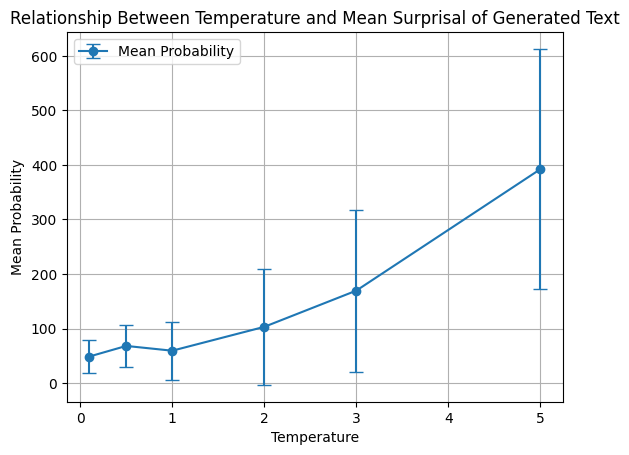

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Generate multiple samples for each temperature and calculate mean and standard deviation
num_samples = 20
mean_probs_per_temp = []
std_devs_per_temp = []
temperatures = [0.1, 0.5, 1.0, 2.0, 3.0, 5.0]

for temp in temperatures:
    probs = []
    print(temp)
    for _ in range(num_samples):
        generated_text = generate(eng_lm, top_k=0, temperature=temp)
        prob = eng_lm.score(generated_text)
        probs.append(prob)
        print(f"Generated text: {generated_text}, Surprisal: {prob}")

    mean_probs_per_temp.append(np.mean(probs))
    std_devs_per_temp.append(np.std(probs))

# Plot the results
plt.errorbar(temperatures, mean_probs_per_temp, yerr=std_devs_per_temp, fmt='o-', capsize=5, label='Mean Probability')
plt.xlabel('Temperature')
plt.ylabel('Mean Probability')
plt.title('Relationship Between Temperature and Mean Surprisal of Generated Text')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# delete short lines
eng = 'lcontent.DACB.DataVirVrystellingOpWeb.(eng-afr).eng.1.0.0.CAM.2010-09-23.txt'
afr = 'lcontent.DACB.DataVirVrystellingOpWeb.(eng-afr).afr.1.0.0.CAM.2010-09-23.txt'
xho = 'Corpus.SADiLaR.English-isiXhosaDrop-Bilingual.1.0.0.CAM.2019-11-15.xh.txt'

def delete_short_lines(file_path, min_length=10):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Filter out lines shorter than min_length
    filtered_lines = [line for line in lines if len(line.strip()) >= min_length]

    # Write the filtered lines back to the file
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(filtered_lines)

delete_short_lines(eng, min_length=15)
delete_short_lines(afr, min_length=15)
delete_short_lines(xho, min_length=15)

In [ ]:
## delete all lines containing a character not in the set of characters
def delete_lines_with_chars(chars):
    with open(eng, 'r', encoding='utf-8') as f:
        eng_txt = f.readlines()
    with open(afr, 'r', encoding='utf-8') as f:
        afr_txt = f.readlines()
    with open(xho, 'r', encoding='utf-8') as f:
        xho_txt = f.readlines()

    # filter lines that do not contain any of the characters
    eng_txt = [line for line in eng_txt if not any(char in line for char in chars)]
    afr_txt = [line for line in afr_txt if not any(char in line for char in chars)]
    xho_txt = [line for line in xho_txt if not any(char in line for char in chars)]

    # write the filtered lines back to the files
    with open(eng, 'w', encoding='utf-8') as f:
        f.writelines(eng_txt)
    with open(afr, 'w', encoding='utf-8') as f:
        f.writelines(afr_txt)
    with open(xho, 'w', encoding='utf-8') as f:
        f.writelines(xho_txt)

delete_lines_with_chars(['=', '|', '>', '@', '&', '’', '―', 'ï', '<'])

In [ ]:
import re

def replace_rare_chars(text, rare_chars, replace_with='�'):
    with open(eng, 'r', encoding='utf-8') as f:
        eng_txt = f.read()
    with open(afr, 'r', encoding='utf-8') as f:
        afr_txt = f.read()
    with open(xho, 'r', encoding='utf-8') as f:
        xho_txt = f.read()

    # replace rare characters with the specified replacement character
    eng_txt = re.sub(f"[{''.join(rare_chars)}]", replace_with, eng_txt)
    afr_txt = re.sub(f"[{''.join(rare_chars)}]", replace_with, afr_txt)
    xho_txt = re.sub(f"[{''.join(rare_chars)}]", replace_with, xho_txt)
        afr_txt = afr_txt.replace(char, replace_with)
        xho_txt = xho_txt.replace(char, replace_with)

    # write the modified texts back to the files
    with open(eng, 'w', encoding='utf-8') as f:
        f.write(eng_txt)
    with open(afr, 'w', encoding='utf-8') as f:
        f.write(afr_txt)
    with open(xho, 'w', encoding='utf-8') as f:
        f.write(xho_txt)
